# XGBoost implementation for Time series forecasting in stock prices

pip install xgboost

## Libraries

In [173]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb

## Data preprocessing

The initial hypothesis is that we need to take a look at the fields related to the stock prices and trading sales. In order to analyze if the prices seem to be relevant in the trading volume

In [174]:
df_msft = pd.read_csv('../database/ticker_MSFT.csv')
df_goog = pd.read_csv('../database/ticker_GOOG.csv')
df_v = pd.read_csv('../database/ticker_V.csv')


In [175]:
df_msft

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2021-12-06,323.950012,327.450012,319.230011,326.190002,320.321655,30032600,MSFT
1,2021-12-07,331.640015,335.799988,330.100006,334.920013,328.894592,31021900,MSFT
2,2021-12-08,335.309998,335.500000,330.799988,334.970001,328.943665,24761000,MSFT
3,2021-12-09,334.410004,336.489990,332.119995,333.100006,327.107300,22214200,MSFT
4,2021-12-10,334.980011,343.000000,334.790009,342.540009,336.377502,38095700,MSFT
...,...,...,...,...,...,...,...,...
498,2023-11-29,383.760010,384.299988,377.440002,378.850006,378.850006,28963400,MSFT
499,2023-11-30,378.489990,380.089996,375.470001,378.910004,378.910004,30554400,MSFT
500,2023-12-01,376.760010,378.160004,371.309998,374.510010,374.510010,33020400,MSFT
501,2023-12-04,369.100006,369.519989,362.899994,369.140015,369.140015,32037800,MSFT


Set the 'date' field as an index and making sure it is a datetime and not a string for plotting purposes

In [176]:
def setIndex(df):
    
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    
    return df

In [177]:
df_msft = setIndex(df_msft)

In [178]:
df_msft = df_msft.drop(columns=['Open','High','Low'])

#### Plot Variables

In [179]:
def plotVariables(df,vars, title):
    df[vars].plot(
        figsize=(15,7), 
        title=title,
        subplots = True
    )

    plt.show()

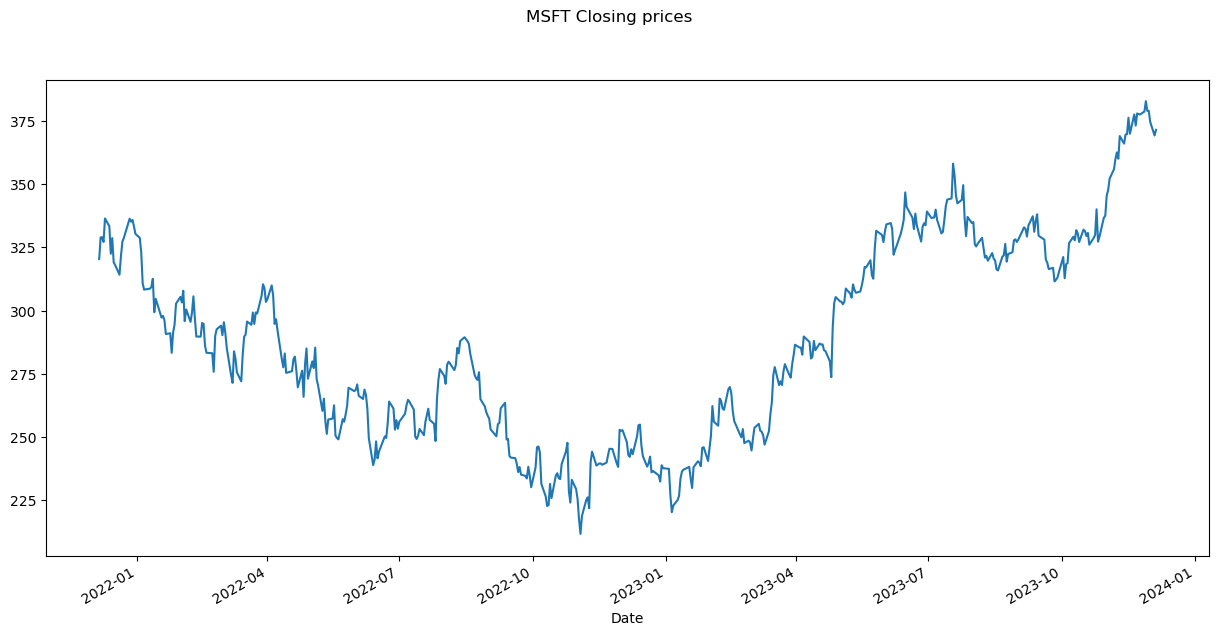

In [180]:
plotVariables(df_msft,'Adj Close','MSFT Closing prices')

## Feature creation

The next step is to create the necessary features for defining the stock's performance and forecast this same metric. Since we have an datetime index we can break this data into its components such as:

- Year
- Month
- Quarter
- Day

In order to get an easier view of the data and how did the stocks performed in different periods of time. 

Also for an accurrate prediction of whether to buy or sell stocks we'll do the calculations of multiple indexes such as the following:

- Relative Strength Index (RSI)
- Stochastic Oscillator
- Williams percentage range
- Moving Average convergence divergence
- Price rate of change
- On balance volume

These are momentum indicators that give buy and sell signals based on their results. We'll have a definition period of 14 days by default for the calculation of these indexes

In [181]:
period = 14

In [182]:
def addGainLoss(df):
    """Calculates gain or loss on the closing price of a stock"""
    df['Gain'] = df['Close'].diff().where(lambda x: x > 0, 0)
    df['Loss'] = abs(df['Close'].diff().where(lambda x: x < 0, 0))
    
    return df

def RSI(df):
    """
    Momentum indication that states if the stock is overbought or oversold
    >70 overbought
    <30 oversold
    """
    
    avg_gain = df['Gain'].rolling(window=period).mean()
    avg_loss = df['Loss'].rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    df['RSI'] = rsi
    return df

def stochasticOscillator(df):
    """
    Follows momentum of the closing price, momentum changes before the price.
    Measures level of the closing price relative to lo-high range in a time period.
    Ranges 0-100
    """
    low = df['Close'].rolling(window=period).min()
    high = df['Close'].rolling(window=period).max()

    osci = 100 * (df['Close']-low)/(high-low)
    df['OSCI'] = osci
    return df

def williamsRate(df):
    """ 
    Momentum indicatior, indicates level of a closing price related to
    the highest price in a time period (14 days). Ranges -100 to 0
    
    >-20 sell signal
    <-80 buy signal
    """
    low = df['Close'].rolling(window=period).min()
    high = df['Close'].rolling(window=period).max()
    
    williams = -100 * (high-df['Close'])/(high-low)
    df['Williams'] = williams
    return df

def movingAverageConvergenceDivergence(df):
    """ 
    Momentum indicator comparing moving averages of prices. A 26 day exponential moving average(EMA) is substracted from a 12 day EMA.
    A 9 day EMA is considered a signal line to compare with the MACD
    
    MACD < EMA9 = sell
    MACD > EMA9 = buy
    """
    
    ema_26 = df['Close'].transform(lambda x: x.ewm(span = 26).mean())
    ema_12 = df['Close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema_12 - ema_26
    
    ema_9_macd = macd.ewm(span = 9).mean()

    df['MACD'] = macd
    df['MACD_SIGNAL'] = ema_9_macd
    
    return df

def rateChange(df):
    """ 
    percentage change in price between the current price and the price over 
    the window that we consider to be the time period of observation.
    """
    df['PROC'] = (df['Close']-df['Close'].shift(period-1))/df['Close'].shift(period-1)
    return df

def onBalanceVolume(df):
    """ 
    uses changes in volume to estimate change in prices. 
    Finds buying and selling trends using the cumulative volumne 
    when the prices go up and substracts volume if they go down.
    Comparing to the previous day
    
    Falling trend -> sell
    Rising trend -> buy
    
    both price and OBV in uptrend -> buy
    both price and OBV in downtrend -> sell
    
    price up, obv not -> sell
    price down, obv not -> buy

    """
    # Grab the volume and close column.
    volume = df['Volume']
    change = df['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    df['OBV'] = obv_values
    
    return df

def addClassLabel(df):
    """ 
    Create target feature for the prediction.
    Based on the change in prices.
    """
    
    df['Class'] = np.sign(df['Close'].diff()).fillna(0)
    df['Class'] = df['Class'].replace(0, 1)
    df['Class'] = df['Class'].replace(-1, 0)


    return df

In [183]:
def addFeatures(df):
    
    df = addGainLoss(df)
    df = RSI(df)
    df = stochasticOscillator(df)
    df = williamsRate(df)
    df = rateChange(df)
    df = onBalanceVolume(df)
    df = movingAverageConvergenceDivergence(df)
    df = addClassLabel(df)
    
    return df

In [184]:
df_msft = addFeatures(df_msft)
df_msft

,Close,Adj Close,Volume,Symbol,Gain,Loss,RSI,OSCI,Williams,PROC,OBV,MACD,MACD_SIGNAL,Class
Date,,,,,,,,,,,,,,
2021-12-06,326.190002,320.321655,30032600,MSFT,0.000000,0.000000,NaN,NaN,NaN,NaN,0,0.000000,0.000000,1.0
2021-12-07,334.920013,328.894592,31021900,MSFT,8.730011,0.000000,NaN,NaN,NaN,NaN,31021900,0.195866,0.108814,1.0
2021-12-08,334.970001,328.943665,24761000,MSFT,0.049988,0.000000,NaN,NaN,NaN,NaN,55782900,0.251122,0.167137,1.0
2021-12-09,333.100006,327.107300,22214200,MSFT,0.000000,1.869995,NaN,NaN,NaN,NaN,33568700,0.202584,0.179145,0.0
2021-12-10,342.540009,336.377502,38095700,MSFT,9.440002,0.000000,NaN,NaN,NaN,NaN,71664400,0.547583,0.288747,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,378.850006,378.850006,28963400,MSFT,0.000000,3.850006,63.545076,82.507931,-17.492069,0.050348,-62257400,10.916652,10.855845,0.0
2023-11-30,378.910004,378.910004,30554400,MSFT,0.059998,0.000000,66.467813,76.342048,-23.657952,0.024995,-31703000,10.522445,10.789165,1.0
2023-12-01,374.510010,374.510010,33020400,MSFT,0.000000,4.399994,54.769407,48.876452,-51.123548,0.021354,-64723400,9.742684,10.579869,0.0


## Create our model

In [185]:
FEATURES = ['RSI','OSCI','Williams','PROC','OBV','MACD']
TARGET = 'Class'

split_date = '2023-01-01'
df_train = df_msft[df_msft.index < split_date]
df_test = df_msft[df_msft.index >= split_date]

Set get the desired features from our dataframes

In [186]:
X_train = df_train[FEATURES]
y_train = df_train[TARGET]

X_test = df_test[FEATURES]
y_test = df_test[TARGET]

In [187]:
model = xgb.XGBClassifier()

model.fit(
    X_train,
    y_train,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [188]:
df_train['Class'].value_counts()

Class
0.0    145
1.0    125
Name: count, dtype: int64

In [189]:
fi = pd.DataFrame(
    data = model.feature_importances_, 
    index=model.feature_names_in_,
    columns=['importance']
    )

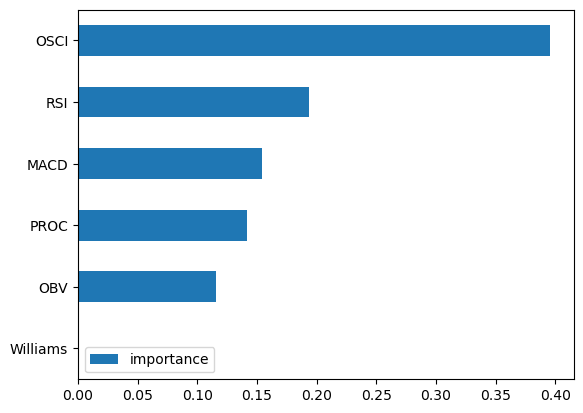

In [190]:
fi.sort_values('importance').plot(kind='barh')
plt.show()

In [191]:
y_pred = model.predict(X_test)
df_test.loc[:, 'Predicted'] = y_pred

C:\Users\guzma\AppData\Local\Temp\ipykernel_20896\389496473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'Predicted'] = y_pred


In [192]:
df_test

,Close,Adj Close,Volume,Symbol,Gain,Loss,RSI,OSCI,Williams,PROC,OBV,MACD,MACD_SIGNAL,Class,Predicted
Date,,,,,,,,,,,,,,,
2023-01-03,239.580002,237.474335,25740000,MSFT,0.000000,0.240005,35.422774,22.256512,-77.743488,-0.067492,-620592400,-1.489172,-0.448324,0.0,1
2023-01-04,229.100006,227.086441,50623400,MSFT,0.000000,10.479996,22.411708,0.000000,-100.000000,-0.109323,-671215800,-2.337245,-0.826108,0.0,0
2023-01-05,222.309998,220.356125,39585600,MSFT,0.000000,6.790009,19.328747,0.000000,-100.000000,-0.107225,-710801400,-3.516708,-1.364228,0.0,0
2023-01-06,224.929993,222.953110,43613600,MSFT,2.619995,0.000000,26.539342,11.706857,-88.293143,-0.080755,-667187800,-4.191709,-1.929724,1.0,1
2023-01-09,227.119995,225.123825,27369800,MSFT,2.190002,0.000000,32.140661,21.745021,-78.254979,-0.055438,-639818000,-4.498087,-2.443397,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,378.850006,378.850006,28963400,MSFT,0.000000,3.850006,63.545076,82.507931,-17.492069,0.050348,-62257400,10.916652,10.855845,0.0,0
2023-11-30,378.910004,378.910004,30554400,MSFT,0.059998,0.000000,66.467813,76.342048,-23.657952,0.024995,-31703000,10.522445,10.789165,1.0,0
2023-12-01,374.510010,374.510010,33020400,MSFT,0.000000,4.399994,54.769407,48.876452,-51.123548,0.021354,-64723400,9.742684,10.579869,0.0,0


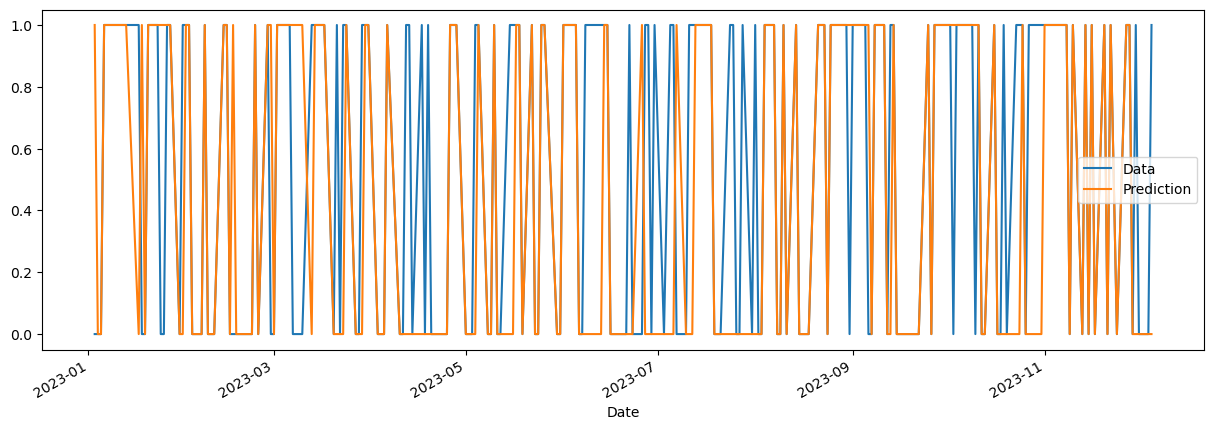

In [193]:
ax = df_test[['Class']].plot(figsize=(15,5))
df_test['Predicted'].plot(ax=ax)
plt.legend(['Data','Prediction'])
plt.show()

In [194]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [195]:
print(accuracy*100)

76.82403433476395


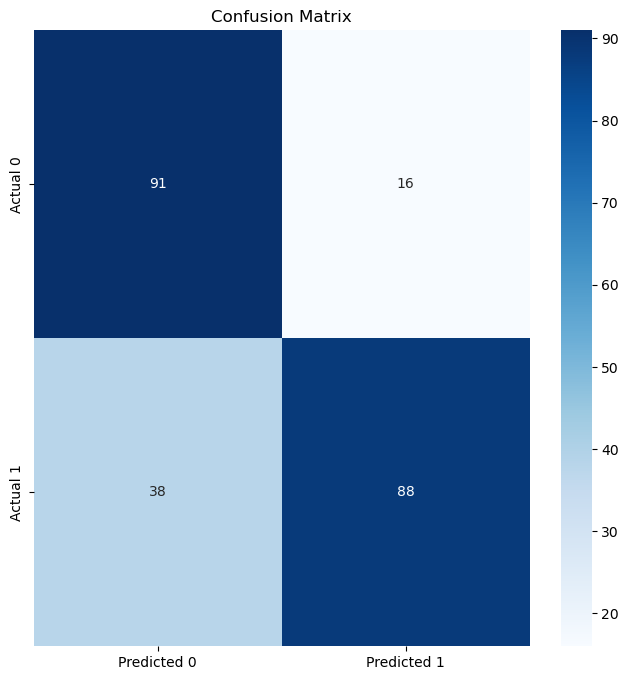

In [200]:
# Plot as a pie chart
plt.figure(figsize=(8, 8))

sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=['Predicted 0', 'Predicted 1'], 
    yticklabels=['Actual 0', 'Actual 1']
)

plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(class_report)

              precision    recall  f1-score   support

         0.0       0.71      0.85      0.77       107
         1.0       0.85      0.70      0.77       126

    accuracy                           0.77       233
   macro avg       0.78      0.77      0.77       233
weighted avg       0.78      0.77      0.77       233

